<a href="https://colab.research.google.com/github/Elvira-Zainulina/ml_MRI_age_prediction/blob/master/VAE_C_2_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install torchio

     |████████████████████████████████| 71kB 3.1MB/s 
     |████████████████████████████████| 42.5MB 71kB/s 
  Created wheel for Python-Deprecated: filename=Python_Deprecated-1.1.0-py2.py3-none-any.whl size=3069 sha256=8e29a47291804bd0b269fbe71c4b3896cabe29e824e130a14e112459ec6e6d95
  Stored in directory: /root/.cache/pip/wheels/b8/f1/81/2a12cf4208f219e3f023a6211a47165e74e50d534c6a3c3e64
Successfully built Python-Deprecated


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#VAE-C

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
from scipy import stats

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import gc
from ml_utils.data import S500MRI_Dataset_simple
from ml_utils.data import ImbalancedDatasetSampler
from ml_utils.transforms import RandomFlip
from ml_utils.train_functions import set_random_seeds
from ml_utils.train_functions import training_plot
from ml_utils.train_functions import train_VAE, test_VAE
from ml_utils.uploading import load_data
from models import VAE_age
RND_STATE = 127

If you use TorchIO for your research, please cite the following paper:

Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning
(https://arxiv.org/abs/2003.04696)


### Data uploading

In [0]:
#path consisting datasets that were created in the Data_preparation.ipynb
path = r"drive/My Drive/Colab Notebooks/ml-project/data"

In [0]:
X_train, y_train, g_train = load_data(os.path.join(path, 'train_dataset.npy'))
X_val, y_val, g_val = load_data(os.path.join(path, 'val_dataset.npy'))
X_test, y_test, g_test = load_data(os.path.join(path, 'test_dataset.npy'))

Define transforms for data-augmentation.

In [0]:
composed = transforms.Compose([RandomFlip(axis=0),
                               RandomFlip(axis=1),
                               RandomFlip(axis=2)])

Make the datasets for $2$-class classification (```group_ages``` merges classes)

In [0]:
train_data = S500MRI_Dataset_simple(X_train, g_train, y_train, group_ages=True)
val_data = S500MRI_Dataset_simple(X_val, g_val, y_val, group_ages=True)

test_data = S500MRI_Dataset_simple(X_test, g_test, y_test, group_ages=True)

#### Model training with the best found training parameters


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_random_seeds(seed_value=0, device=device)

net = VAE_age(16, 2, device).to(device)
cross_entropy = nn.CrossEntropyLoss().to(device)
mse_loss = nn.MSELoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)
scheduler = None #optim.lr_scheduler.StepLR(optimizer, 1, gamma=1.-1e-1)

train_dataloader = DataLoader(
    train_data, 
    sampler=ImbalancedDatasetSampler(train_data),
    batch_size=36, 
    num_workers=4
)
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=False, num_workers=4)

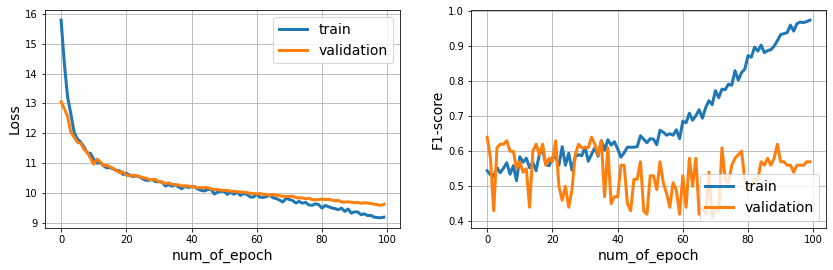

Epoch 99: train_loss 9.1811, val_loss 9.6150 	train_f1_score 0.9743, val_f1_score 0.5700 
Finished training.


In [0]:
(losses, losses_dev,
 f1_scores, f1_scores_dev) = train_VAE(train_dataloader, val_dataloader, net, 
                                       optimizer, mse_loss, cross_entropy, 100, 
                                       scheduler=scheduler, device=device, 
                                       draw=True, verbose=True,
                                       output_clf=os.path.join(path, 'VAE_clf_2.pt'))

Save learning curve

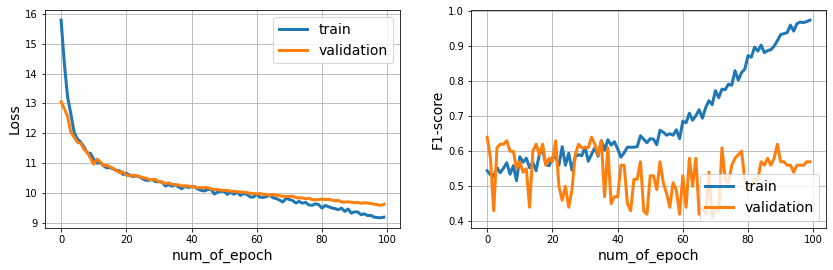

In [0]:
training_plot(losses, losses_dev, f1_scores, f1_scores_dev, 
              os.path.join(path, 'VAE_clf_2.pdf'))

Obtain scores on train, validation, test sets.

In [0]:
net = torch.load(os.path.join(path, 'VAE_clf_2.pt'))
tr_dl = DataLoader(train_data, batch_size=20, shuffle=False, num_workers=4) 
_, tr_f1 = test_VAE(tr_dl, net, mse_loss, cross_entropy, device=device)
print('Train f1-score:', tr_f1)
val_dl = DataLoader(val_data, batch_size=20, shuffle=False, num_workers=4) 
_, val_f1 = test_VAE(val_dl, net, mse_loss, cross_entropy, device=device)
print('Validation f1-score:', val_f1)
test_dl = DataLoader(test_data, batch_size=20, shuffle=False, num_workers=4) 
_, test_f1 = test_VAE(test_dl, net, mse_loss, cross_entropy, device=device)
print('Test f1-score:', test_f1)


Train f1-score: 1.0



Validation f1-score: 0.57



Test f1-score: 0.6262626262626263


Due to the limitation of the Colab-notebooks and long time of the model training no other experimants are saved.